# A toolkit of functions for the retrieval and preprocessing of climate and meteorological data

##### This notebook contains an hands-on example of how retrieve Reanalyses climatological data from Copernicus Data Store (CDS) and perform on them temporal and spatial manipulation.

### Imports

In [12]:
import cdsapi
import xarray as xr
from datetime import datetime
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import proplot as plot

/opt/anaconda3/envs/aria_env/lib/python3.8/site-packages/proplot/__init__.py:71: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


### Download from CDS

This section constructs a request dictionary in accordance with the specifications provided by the CDS API. Initially, it delineates the variable of interest, specifying the data to be extracted. Subsequently, it designates the geographical area from which the data should be retrieved and identifies the date for which the data is required. <br>
<br>
To obtain the key it is necessary to register to CDS platform.<br> Replace _UID_ and _API KEY_ with the personal keys.<br>
Please refer to https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation for all the variables anda datasets available in the repository

In [3]:
def get_client():

    key = '<UID>:<API Key>'
    c = cdsapi.Client(url = 'https://cds.climate.copernicus.eu/api/v2',
                key = str(key))

    return c

def request_builder(date, variable, area_bounds):
        """
        Return the dictionary request for CDS

        :param area_bounds: cutting area
        :param year: year of interest
        :param month: month of interest
        :return:
        """

        request_dict = {
            'format': 'netcdf',
            'variable': variable,
            'year': date.year,
            'month': date.month,
            'day': date.day,
            'time': [
                '00:00', '01:00', '02:00',
                '03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00',
                '09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00',
                '15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00',
                '21:00', '22:00', '23:00',
            ]
        }

        request_dict['product_type'] = 'reanalysis'
        request_dict['area'] = area_bounds

        return request_dict

Data is available through NetCDF format

#### Download U component of the wind

In [4]:
data_source = 'reanalysis-era5-single-levels'
variable = '10m_u_component_of_wind'
date_string = '2023-10-01'

# Corresponds to Europe coords box
area_bounds = [75, -25, 32, 48.5]

date = datetime.strptime(date_string, '%Y-%m-%d')

In [5]:
request_dict = request_builder(date, variable, area_bounds)
c = get_client()

filename = f'data/{data_source}_{variable}_{date.year}{date.month:02d}{date.day:02d}.nc'

c.retrieve(data_source, request_dict, filename)

2023-10-16 11:14:18,316 INFO Welcome to the CDS
2023-10-16 11:14:18,317 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-10-16 11:14:18,442 INFO Request is queued
2023-10-16 11:14:19,463 INFO Request is running
2023-10-16 11:14:23,257 INFO Request is completed
2023-10-16 11:14:23,259 INFO Downloading https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data3/adaptor.mars.internal-1697447661.3457623-18103-17-fab3f423-abd2-448f-9695-e648e78a9a28.nc to data/reanalysis-era5-single-levels_10m_u_component_of_wind_20231001.nc (2.3M)
2023-10-16 11:14:23,757 INFO Download rate 4.7M/s   


Result(content_length=2452732,content_type=application/x-netcdf,location=https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data3/adaptor.mars.internal-1697447661.3457623-18103-17-fab3f423-abd2-448f-9695-e648e78a9a28.nc)

#### Download V component of the wind

In [5]:
variable = '10m_v_component_of_wind'

In [6]:
request_dict = request_builder(date, variable, area_bounds)
c = get_client()

filename = f'data/{data_source}_{variable}_{date.year}{date.month:02d}{date.day:02d}.nc'
c.retrieve(data_source, request_dict, filename)

2023-10-13 18:33:01,937 INFO Welcome to the CDS
2023-10-13 18:33:01,938 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-10-13 18:33:02,083 INFO Request is completed
2023-10-13 18:33:02,084 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data2/adaptor.mars.internal-1697207437.7641194-7427-9-71172021-882a-4ba7-8066-d199dc9f2bd8.nc to data/reanalysis-era5-single-levels_10m_v_component_of_wind_20231001.nc (2.3M)
2023-10-13 18:33:02,379 INFO Download rate 7.9M/s   


Result(content_length=2452732,content_type=application/x-netcdf,location=https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data2/adaptor.mars.internal-1697207437.7641194-7427-9-71172021-882a-4ba7-8066-d199dc9f2bd8.nc)

### Processing Wind Speed and make other manipulation

In this section we first compute wind speed calculation from its components, then we perform different example of aggregations and plot. At the end, we save new files on disk.In this section, we initially calculate the wind speed using its component velocities. Following that, we explore various examples of data aggregations and generate corresponding plots for visualization. Finally, we store the newly created files onto the disk for future use.

In [6]:
def compute_wind_speed(u, v):
    return np.sqrt(u**2 + v**2)

In [7]:
# Open the dataset and merge them in one object
ds = xr.open_mfdataset('data/*')

In [8]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 295, latitude: 173, time: 24)
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.75 -24.5 -24.25 ... 48.0 48.25 48.5
  * latitude   (latitude) float32 75.0 74.75 74.5 74.25 ... 32.5 32.25 32.0
  * time       (time) datetime64[ns] 2023-10-01 ... 2023-10-01T23:00:00
Data variables:
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(24, 173, 295), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(24, 173, 295), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-16 09:14:21 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [9]:
ds_ws = compute_wind_speed(ds.u10, ds.v10)
ds_ws.name = 'ws'

In [10]:
ds_ws

<xarray.DataArray 'ws' (time: 24, latitude: 173, longitude: 295)>
dask.array<sqrt, shape=(24, 173, 295), dtype=float32, chunksize=(24, 173, 295), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.75 -24.5 -24.25 ... 48.0 48.25 48.5
  * latitude   (latitude) float32 75.0 74.75 74.5 74.25 ... 32.5 32.25 32.0
  * time       (time) datetime64[ns] 2023-10-01 ... 2023-10-01T23:00:00

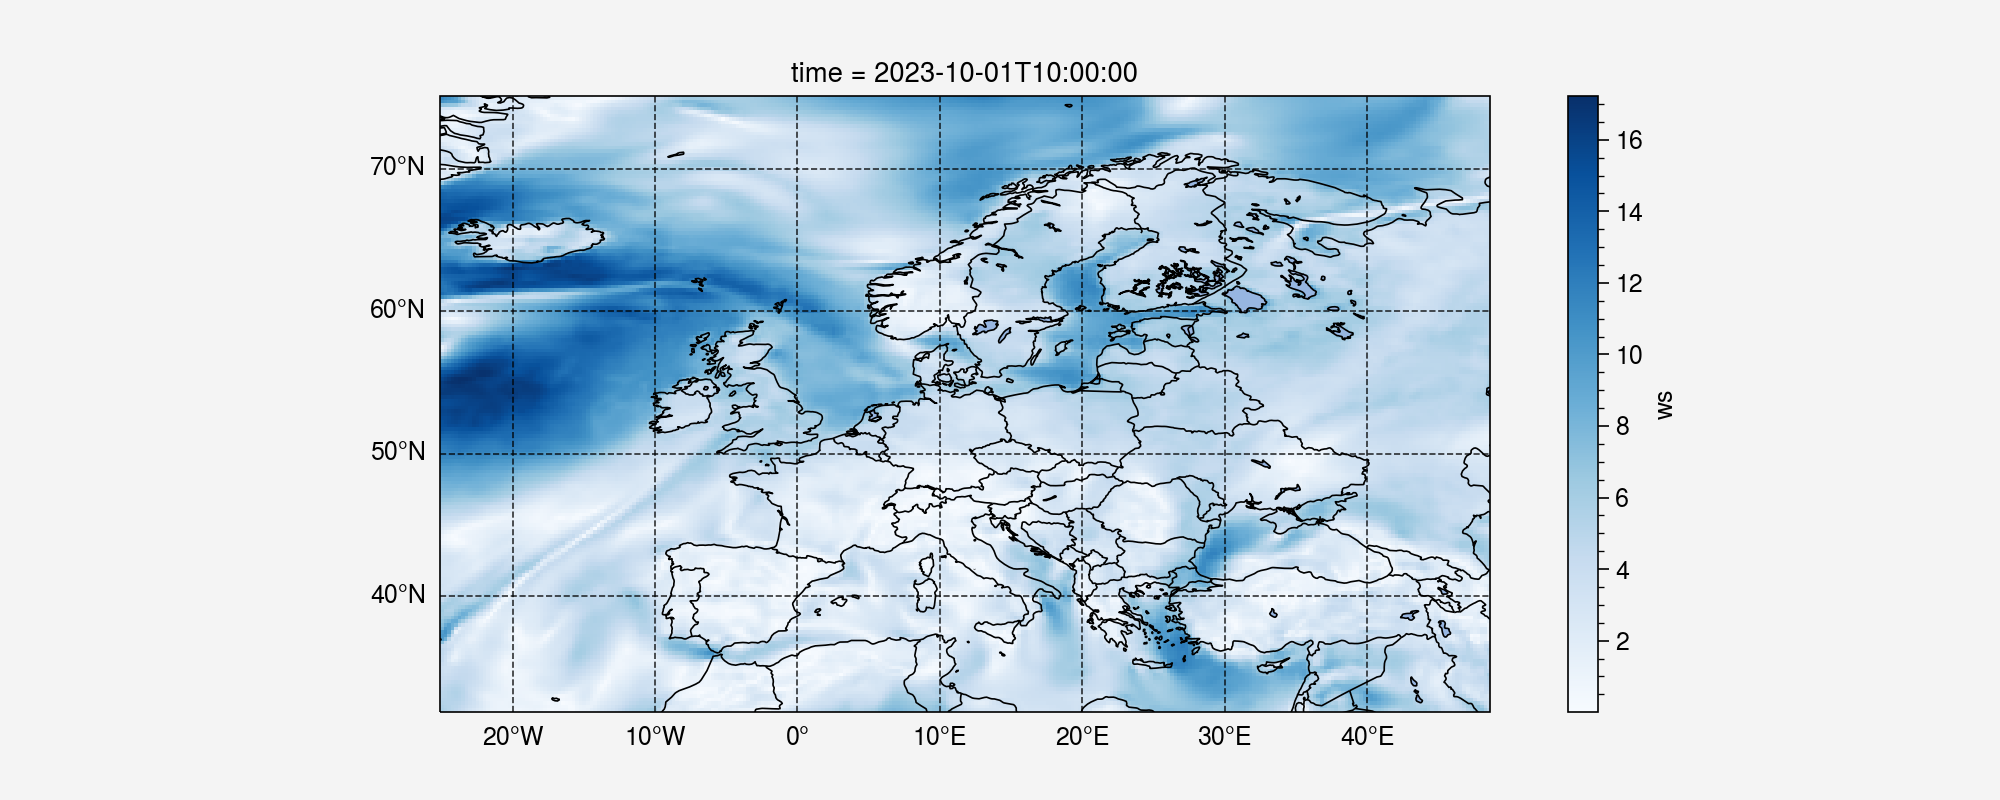

In [24]:
fig, ax = plt.subplots(1,1, figsize=(10,4), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = 'Blues'

im = xr.plot.imshow(ds_ws[10,:,:], cmap=cmap, ax = ax)
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black')
ax.add_feature(cfeature.BORDERS, edgecolor='black')

gl=ax.gridlines(draw_labels=True, alpha=0.8, linestyle='--')
gl.top_labels = False
gl.right_labels = False
    


#### Compute daily average

In [14]:
ds_daily = ds_ws.mean(dim='time')

In [15]:
ds_daily

<xarray.DataArray 'ws' (latitude: 173, longitude: 295)>
dask.array<mean_agg-aggregate, shape=(173, 295), dtype=float32, chunksize=(173, 295), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.75 -24.5 -24.25 ... 48.0 48.25 48.5
  * latitude   (latitude) float32 75.0 74.75 74.5 74.25 ... 32.5 32.25 32.0

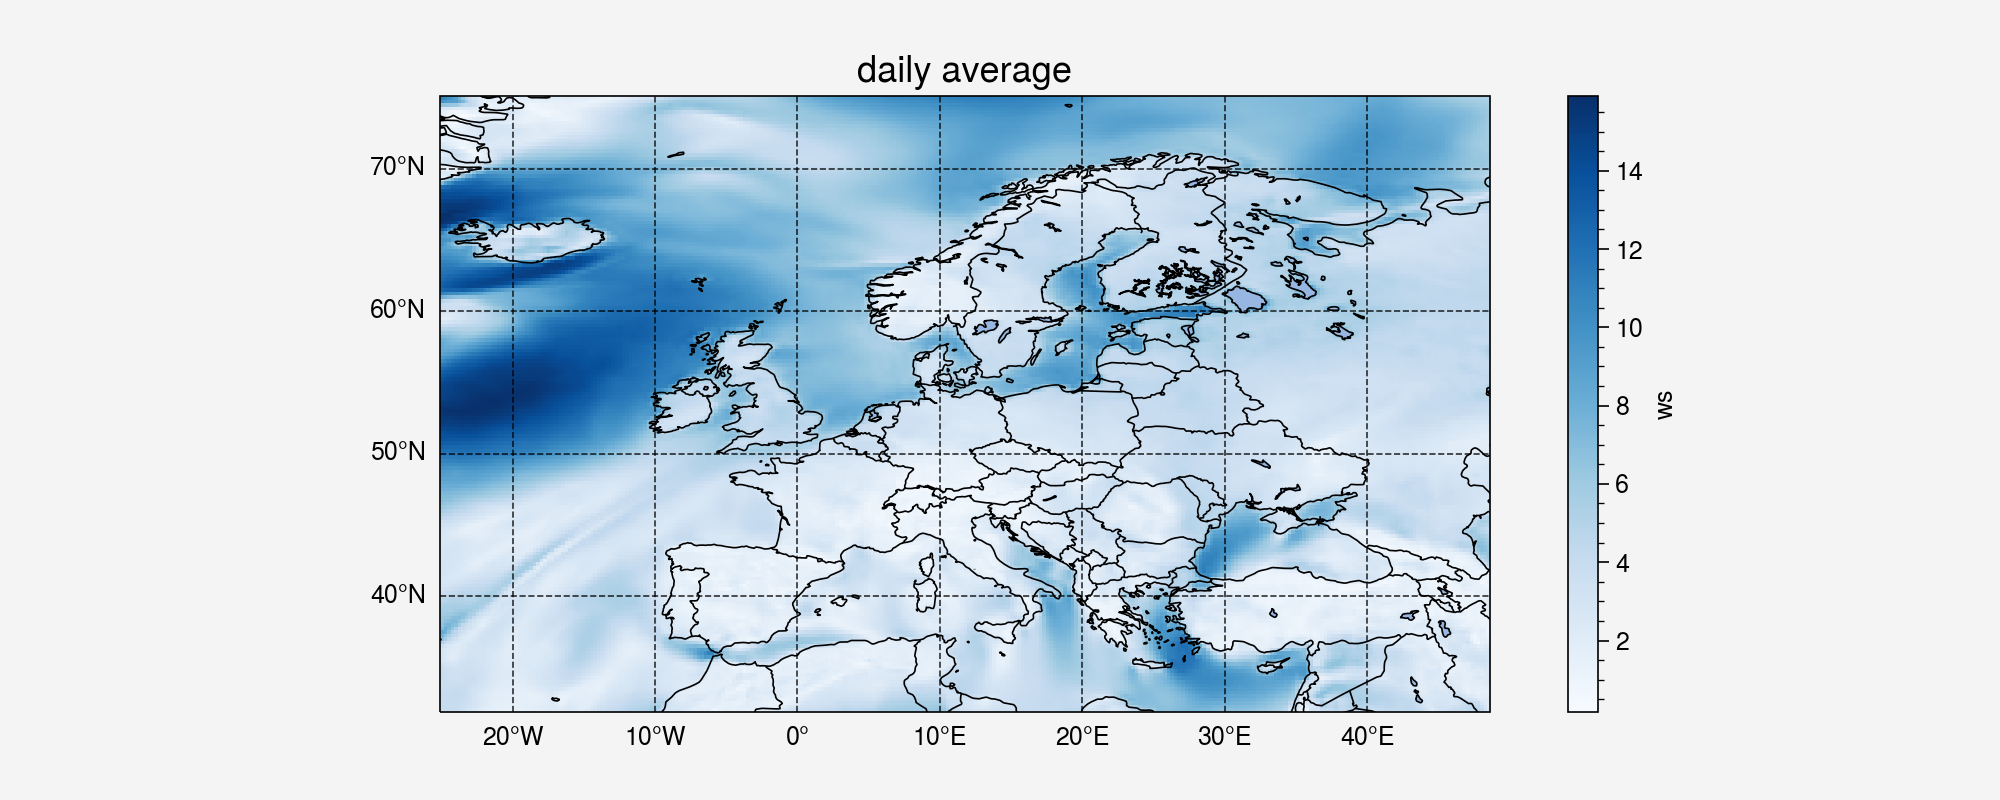

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10,4), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = 'Blues'

im = xr.plot.imshow(ds_daily, cmap=cmap, ax = ax)
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black')
ax.add_feature(cfeature.BORDERS, edgecolor='black')
ax.set_title(f'daily average', fontsize=13)

gl=ax.gridlines(draw_labels=True, alpha=0.8, linestyle='--')
gl.top_labels = False
gl.right_labels = False

#### Select a box

In [17]:
ds_area = ds_ws.sel(latitude=slice(48,35), longitude=slice(5,20))

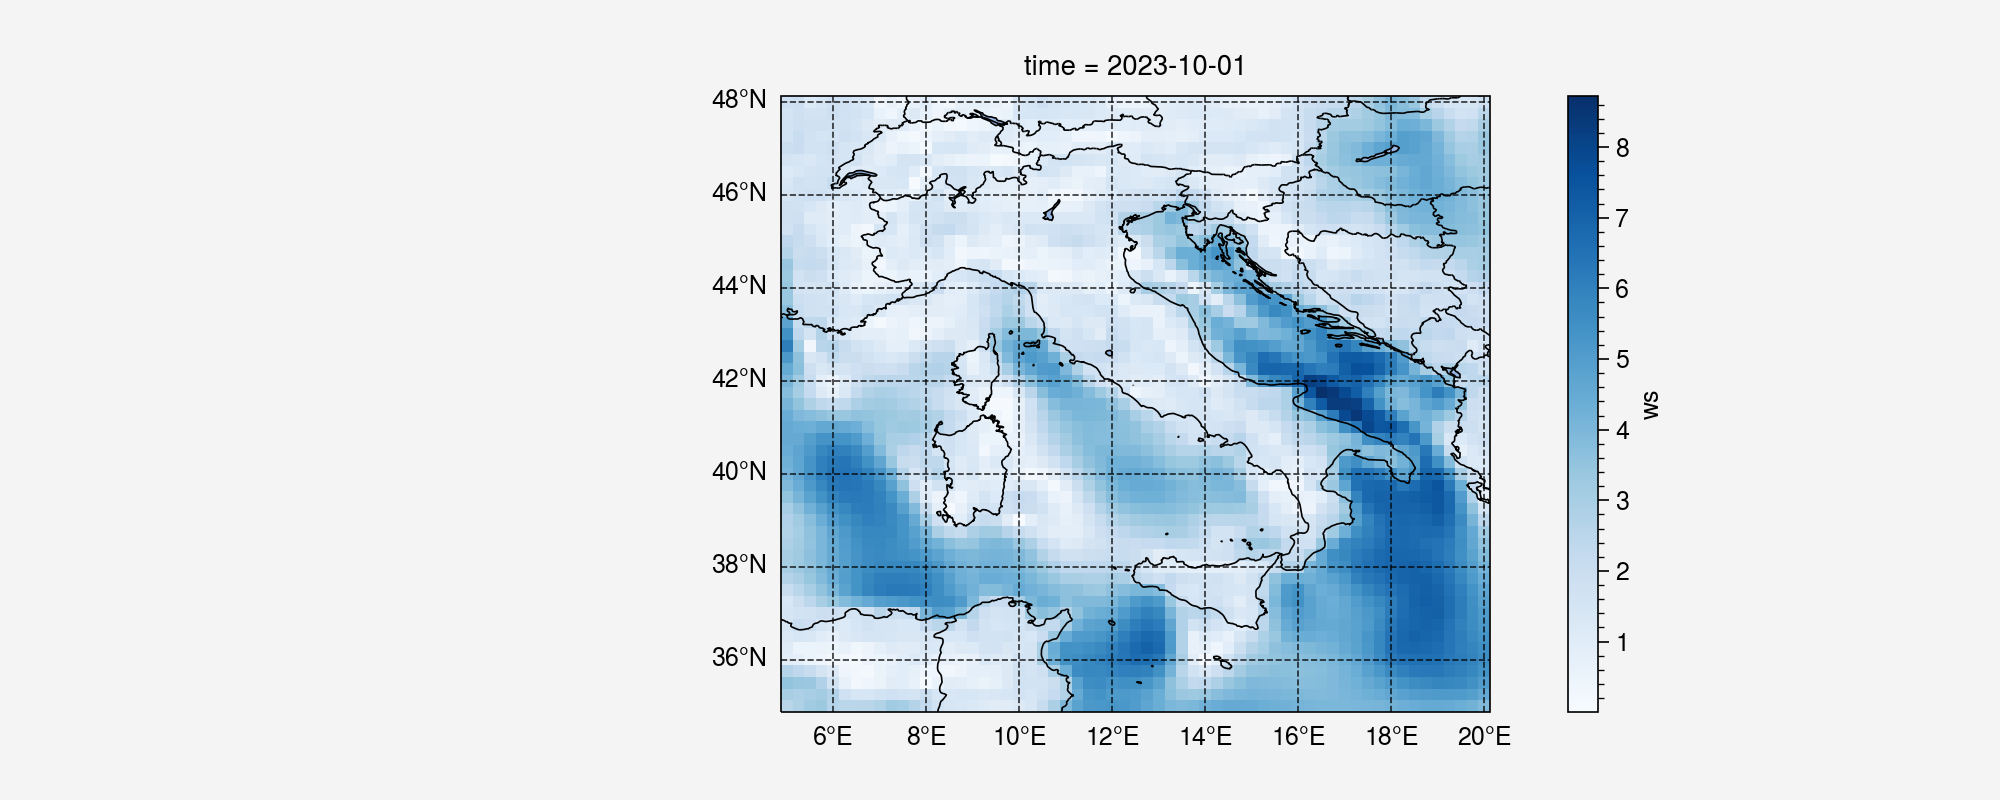

In [28]:
fig, ax = plt.subplots(1,1, figsize=(10,4), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = 'Blues'

im = xr.plot.imshow(ds_area[0,:,:], cmap=cmap, ax = ax)
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black')
ax.add_feature(cfeature.BORDERS, edgecolor='black')

gl=ax.gridlines(draw_labels=True, alpha=0.8, linestyle='--')
gl.top_labels = False
gl.right_labels = False

